# Asymmetric Markov Chain Tutorial
This notebook demonstrates the knockoff construction for the asymmetric Markov Chain experiments. The data is generated as follows. Let
$$
Z_j\stackrel{i.i.d.}{\sim} \frac{I\cdot \mid  Y_\text{G} \mid  -(1-I)\cdot Y_\text{E}- \mu}{\sigma} \ \text{ for } j=1,\dots,p,
$$
where $\mu$ and $\sigma$ are chosen so that the variables are centered with unit variance, and then define
$$
X_1=Z_1, \quad X_{j+1}=\rho_j X_j + \sqrt{1-\rho_j^2}Z_{j+1} \ \text{ for } j=2,\dots,p.
$$
Section 5.2.2 of the accompanying paper presents a large set of simulation results in this setting.

## Multiple-try Metropolis

We demonstrate the Multiple-try Metropolis (Section 3.3 of the paper) proposals below.

In [101]:
import math
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
import seaborn as sns

%run ../asymmetric/asym_core

In [90]:
#simulation parameters
p = 30 # dimension of the random vector X
numsamples = 200 # number of samples to generate knockoffs for
rhos = [0.6]*(p-1) # the correlations

#algorithm parameters
halfnumtry = 2 # m/half number of candidates
stepsize = 1.5 # step size in the unit of 1/\sqrt((\Sigma)^{-1}_{jj})

#distributional constants
asymean = 1/math.sqrt(2*math.pi) - 1/2
variance = 1.5 - (1/math.sqrt(2*math.pi)- 1/2)**2 

We first compute the proposal scaling for each variable. Recall that the recommended scaling for the proposal for variable $j$ is $\sqrt{(\Sigma^{-1})_{jj}}$ (Section 3.3 of the paper).

In [91]:
#generate the proposal grid
quantile_x = np.zeros([p,2*halfnumtry+1])
sds = [0]*p
sds[0] = math.sqrt(1-rhos[0]**2)
for i in range(1,p-1):
    sds[i] = math.sqrt((1 - rhos[i - 1]**2)*(1 - rhos[i]**2) /
                       (1 - rhos[i - 1]**2*rhos[i]**2))
sds[p - 1] = math.sqrt(1 - rhos[p - 2]**2)
for i in range(p):
    quantile_x[i] = [x*sds[i]*stepsize for x in list(
        range(-halfnumtry, halfnumtry + 1))]

Next, we sample observations from the Markov Chain and generate knockoffs with the MTM technique using the `SCEP_MH_MC` function.

In [92]:
bigmatrix = np.zeros([numsamples,2*p]) #store simulation data

#generate each observation and knockoff
start = time.time()
for i in range(numsamples):
    #sample one instance from the Markov Chain
    if np.random.uniform() >= 0.5:
            bigmatrix[i, 0] = (abs(np.random.normal()) - asymean) / \
                math.sqrt(variance)
    else:
        bigmatrix[i, 0] = (log(np.random.uniform()) - asymean) / \
            math.sqrt(variance) 
        # log(np.random.uniform()) is a negative exponential 
    for j in range(1, p):
        if np.random.uniform() >= 0.5:
            bigmatrix[i,j] = ((abs(np.random.normal()) - asymean)/  
                              math.sqrt(variance)) * \
                math.sqrt(1 - rhos[j - 1]**2) + rhos[j - 1] * \
                bigmatrix[i,j - 1]
        else:
            bigmatrix[i, j] =  ((log(np.random.uniform())-asymean)/ 
                                math.sqrt(variance)) * \
                math.sqrt(1- rhos[j - 1]**2) + rhos[j - 1] * \
                bigmatrix[i, j - 1]
    
    #generate a knockoff for the observation
    bigmatrix[i, p:(2*p)] = SCEP_MH_MC(bigmatrix[i, 0:p], 0.999, 
                                       quantile_x, rhos)
    
end = time.time()

print("Average time per observation + knockoff (seconds): " + \
      '%.3f'%((end - start) / numsamples))    
    
np.shape(bigmatrix)

Average time per observation + knockoff (seconds): 0.058


(200, 60)

We can evaluate the quality of these knocokffs by computing the average correlation between $X_{i,j}$ and $\tilde{X}_{i,j}$.

In [93]:
cors = []
for j in range(p):
    cors += [np.corrcoef(bigmatrix[:, j], bigmatrix[:, j + p])[0, 1]]
np.mean(cors)                    

0.5936907282603322

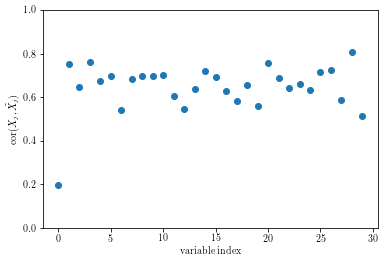

In [110]:
plt.scatter(range(p), cors)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.ylim(0,1)
plt.ylabel(r"cor$(X_j, \tilde{X_j})$")
plt.xlabel("variable index")
plt.show()

## Covariance-guided proposals

In [94]:
# solve the sdp to find the 
# optimal proposal parameters
param_list = compute_proposals(rhos) 

     pcost       dcost       gap    pres   dres   k/t
 0: -3.0000e+01 -1.5000e+02  3e+02  9e-01  1e+00  1e+00
 1: -2.4222e+01 -4.8476e+01  3e+01  2e-01  3e-01  4e-01
 2: -2.1826e+01 -4.4226e+01  3e+01  2e-01  3e-01  4e-01
 3: -1.5998e+01 -1.9659e+01  5e+00  3e-02  4e-02  7e-02
 4: -1.5878e+01 -1.6094e+01  3e-01  2e-03  2e-03  4e-03
 5: -1.5835e+01 -1.5916e+01  1e-01  6e-04  9e-04  2e-03
 6: -1.5814e+01 -1.5819e+01  6e-03  4e-05  6e-05  1e-04
 7: -1.5813e+01 -1.5813e+01  4e-04  2e-06  3e-06  6e-06
 8: -1.5813e+01 -1.5813e+01  1e-04  6e-07  1e-06  1e-06
 9: -1.5813e+01 -1.5813e+01  2e-06  1e-08  2e-08  3e-08
Optimal solution found.
0.4729166501155528


In [95]:
bigmatrix_cov = bigmatrix.copy() #use the samples from MTM

start = time.time()
for i in range(numsamples):   
    #generate a knockoff for the observation
    bigmatrix_cov[i, p:(2*p)] = SCEP_MH_COV(bigmatrix_cov[i, 0:p], 0.999, 
                                       np.zeros(p), rhos, param_list)
end = time.time()

print("Average time per observation + knockoff (seconds): " + \
      '%.3f'%((end - start) / numsamples))    
    
np.shape(bigmatrix)

Average time per observation + knockoff (seconds): 0.005


(200, 60)

In [96]:
cors = []
for j in range(p):
    cors += [np.corrcoef(bigmatrix_cov[:, j], bigmatrix_cov[:, j + p])[0, 1]]
np.mean(cors)   

0.6478354057715047

In [ ]:
plt.scatter(range(p), cors)
plt.ylim(0,1)
plt.show()